<a href="https://colab.research.google.com/github/vijaydsv1/Health-Insurance-Cross-Sell-Prediction/blob/main/_Health_Insurance_Cross_Sell_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'health-insurance-cross-sell-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F869050%2F1480773%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240703%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240703T170020Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9ffe02a2bdd75e7b50f0bdda530bcf737af7e4e80450097247b09d193fb3aeffd9169352c358cde694e8ef417880330b0ce0595f5d9cfb7b31b99796ebbdf7113350af316b944c694990ab1ed1ff503ac4e7ba2fad9888e7a789dce74f6b331a1486481eaf726148e4c0b36b1389282faab1d70f9a0c597d0af10d0f9bad8967be6186aa8fa552dbb547efb761902abc316b25f6e6b7ec719de493ac99ddd21ecce4e9cc0afe2f7c7fe77b457c5c0b23af8336c8238ee15fe835553c90637033d3539c3d558cc6cf6ddd2dd281430fac4cd3725115665a2295b676fbc999b5506955fe8c3af322abe2aa8521ca84d773c3d77ec02a75d999f807ea11480432b1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6782114 bytes downloaded
Downloaded and uncompressed: health-insurance-cross-sell-prediction
Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [3]:
train_data = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv')
test_data = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/test.csv')
sample_submission = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv')


In [4]:
train_data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [5]:
test_data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297
...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,Female,26,1,37.0,1,< 1 Year,No,30867.0,152.0,56
127033,508143,Female,38,1,28.0,0,1-2 Year,Yes,28700.0,122.0,165
127034,508144,Male,21,1,46.0,1,< 1 Year,No,29802.0,152.0,74
127035,508145,Male,71,1,28.0,1,1-2 Year,No,62875.0,26.0,265


In [6]:
sample_submission

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0
...,...,...
127032,508142,0
127033,508143,0
127034,508144,0
127035,508145,0


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [8]:
train_data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [9]:
test_data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [10]:
binary_feature = ['Gender', 'Vehicle_Damage']


In [11]:
train_data['Vehicle_Age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [12]:
def binary_encode(df, column, positive_label):
    df[column] = df[column].apply(lambda x: 1 if x == positive_label else 0)
    return df

In [13]:
train_data = binary_encode(train_data, 'Gender', 'Male')

In [14]:
test_data = binary_encode(test_data, 'Gender', 'Male')

In [15]:
train_data = binary_encode(train_data, 'Vehicle_Damage', 'Yes')

In [16]:
test_data = binary_encode(test_data, 'Vehicle_Damage', 'Yes')

In [17]:
def ordinal_encode(df, column, ordering):
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

In [18]:
ordering_f = ['< 1 Year', '1-2 Year', '> 2 Years']

In [19]:
train_data = ordinal_encode(train_data, 'Vehicle_Age', ordering_f)


In [20]:
test_data = ordinal_encode(test_data, 'Vehicle_Age', ordering_f)


In [21]:
train_data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,74,1,26.0,1,1,0,30170.0,26.0,88,0
381105,381106,1,30,1,37.0,1,0,0,40016.0,152.0,131,0
381106,381107,1,21,1,30.0,1,0,0,35118.0,160.0,161,0
381107,381108,0,68,1,14.0,0,2,1,44617.0,124.0,74,0


In [22]:
test_data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,1,25,1,11.0,1,0,0,35786.0,152.0,53
1,381111,1,40,1,28.0,0,1,1,33762.0,7.0,111
2,381112,1,47,1,28.0,0,1,1,40050.0,124.0,199
3,381113,1,24,1,27.0,1,0,1,37356.0,152.0,187
4,381114,1,27,1,28.0,1,0,0,59097.0,152.0,297
...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,0,26,1,37.0,1,0,0,30867.0,152.0,56
127033,508143,0,38,1,28.0,0,1,1,28700.0,122.0,165
127034,508144,1,21,1,46.0,1,0,0,29802.0,152.0,74
127035,508145,1,71,1,28.0,1,1,0,62875.0,26.0,265


In [23]:
test_ids = test_data['id'].tolist


test_data = test_data.drop('id', axis=1)
train_data = train_data.drop('id', axis=1)

In [24]:
y = train_data['Response']
X = train_data.drop('Response', axis=1)

In [25]:
X

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,44,1,28.0,0,2,1,40454.0,26.0,217
1,1,76,1,3.0,0,1,0,33536.0,26.0,183
2,1,47,1,28.0,0,2,1,38294.0,26.0,27
3,1,21,1,11.0,1,0,0,28619.0,152.0,203
4,0,29,1,41.0,1,0,0,27496.0,152.0,39
...,...,...,...,...,...,...,...,...,...,...
381104,1,74,1,26.0,1,1,0,30170.0,26.0,88
381105,1,30,1,37.0,1,0,0,40016.0,152.0,131
381106,1,21,1,30.0,1,0,0,35118.0,160.0,161
381107,0,68,1,14.0,0,2,1,44617.0,124.0,74


<Axes: >

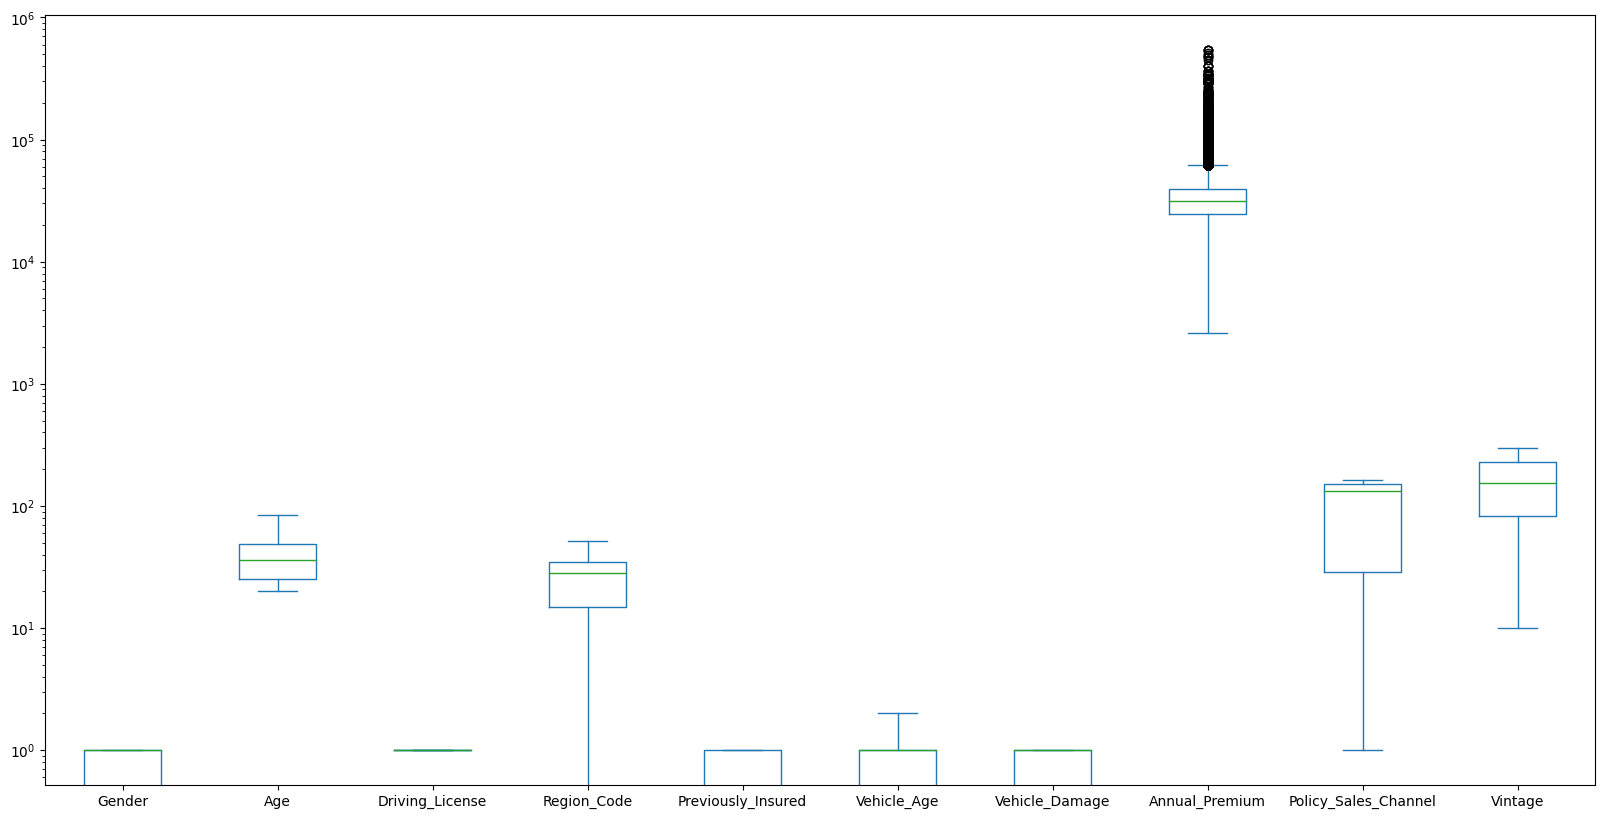

In [26]:
X.plot(kind='box', figsize=(20, 10), logy = True)

In [27]:
scaler = MinMaxScaler()

X = scaler.fit_transform(X)
test_data = scaler.fit_transform(test_data)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [29]:
X.shape

(381109, 10)

In [30]:
y.shape

(381109,)

In [31]:
y.sum()/ len(y)

0.12256336113815208

In [32]:
inputs = tf.keras.Input(shape=(10, ))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(inputs)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

In [33]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = [tf.keras.metrics.AUC(name='auc')]

)

In [ ]:
batch_size = 64
epochs = 25


history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    batch_size = batch_size,
    epochs = epochs,
    verbose=1,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()]
)

Epoch 1/25
3335/3335 [==============================] - 8s 2ms/step - loss: 0.3472 - auc: 0.7005 - val_loss: 0.2939 - val_auc: 0.8111 - lr: 0.0010
Epoch 2/25
3335/3335 [==============================] - 9s 3ms/step - loss: 0.2850 - auc: 0.8190 - val_loss: 0.2819 - val_auc: 0.8235 - lr: 0.0010
Epoch 3/25
3335/3335 [==============================] - 7s 2ms/step - loss: 0.2790 - auc: 0.8261 - val_loss: 0.2794 - val_auc: 0.8273 - lr: 0.0010
Epoch 4/25
3335/3335 [==============================] - 9s 3ms/step - loss: 0.2776 - auc: 0.8287 - val_loss: 0.2790 - val_auc: 0.8284 - lr: 0.0010
Epoch 5/25
3335/3335 [==============================] - 10s 3ms/step - loss: 0.2772 - auc: 0.8296 - val_loss: 0.2787 - val_auc: 0.8288 - lr: 0.0010
Epoch 6/25
3335/3335 [==============================] - 7s 2ms/step - loss: 0.2771 - auc: 0.8301 - val_loss: 0.2787 - val_auc: 0.8289 - lr: 0.0010
Epoch 7/25
3335/3335 [==============================] - 9s 3ms/step - loss: 0.2770 - auc: 0.8304 - val_loss: 0.2788 -

In [ ]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'Epoch', 'value': 'Loss'},
    title = 'Training History')
fig.show()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
preds = model.predict(test_data)

In [ ]:
preds

In [ ]:
preds = list(map(lambda x: np.int64(x[0]), preds >= 0.5))

In [ ]:
submission = pd.concat([pd.Series(test_ids), pd.Series(preds)], axis=1)
submission.columns = ['id', 'Response']

In [ ]:
submission

In [ ]:
sample_submission.shape == submission.shape

In [ ]:
submission.to_csv('./submission.csv')